# Fully connected network eli suomeksi täysin kytketty verkko ja sen  treenaaminen CIFAR-10 datasetillä

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
print(K.backend())

tensorflow


# Datan esikäsittely
Kuvat ovat 32x32 pikseliä ja sisältävät 3 kanavaa (RGB). Jokainen kuva on muunnettu yksiulotteiseksi vektoriksi, jossa on 3072 elementtiä (32 × 32 × 3).

Pikseliarvot on normalisoitu skaalaan 0-1, jotta malli voi oppia tehokkaammin ja minimoida numeristen arvojen aiheuttamat ongelmat.

Testi- ja validointidatan erottelu on tehty validation_split-parametrilla.

Vastemuuttujaa ei ole muutettu one-hot-enkoodattuun muotoon, koska käytämme SparseCategoricalCrossentropy-tappiota, joka tukee suoraan kokonaislukuarvoja (0–9) luokkina.

# Mallin rakennus
Mallissa käytetään useita täysin kytkettyjä Dense kerroksia, joissa on ReLU-aktivaatioita ei-lineaarisuuden lisäämiseksi.

Ensimmäinen kerros sisältää 1024 neuronia, toinen 512 neuronia ja kolmas 256 neuronia.

Viimeinen kerros on 10-neuroninen softmax-kerros, joka tuottaa todennäköisyysjakauman kymmenelle CIFAR-10-luokalle.

Dropout-kerroksia tai normalisointia ei ole käytetty, joten malli pyrkii tehokkaaseen oppimiseen ilman suoranaista yliopetuksen estoa.

Malli käyttää Adam-optimointialgoritmia ja SparseCategoricalCrossentropy-tappiota, joka sopii hyvin usean luokan luokittelutehtäviin.

In [3]:
# Create the model
inputs = keras.Input(shape=(3072,))
x = layers.Dense(1024, activation="relu")(inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")

In [4]:
model.summary()

Model: "cifar10_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,805,450 (14.52 MB)

 Trainable params: 3,805,450 (14.52 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.reshape(50000, 3072).astype("float32") / 255
x_test = x_test.reshape(10000, 3072).astype("float32") / 255

In [6]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

## Mallin kouluttaminen
Malli koulutetaan 15 epookilla ja eräkoko on 500. Validointidata on 20% koulutusdatan koosta.

In [7]:
history = model.fit(x_train, y_train, batch_size=500, epochs=15, validation_split=0.2)

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1729 - loss: 2.4825 - val_accuracy: 0.3054 - val_loss: 1.9192
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3447 - loss: 1.8513 - val_accuracy: 0.3707 - val_loss: 1.7810
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3868 - loss: 1.7233 - val_accuracy: 0.3961 - val_loss: 1.6978
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4121 - loss: 1.6463 - val_accuracy: 0.4080 - val_loss: 1.6724
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4210 - loss: 1.6151 - val_accuracy: 0.4296 - val_loss: 1.5992
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4507 - loss: 1.5443 - val_accuracy: 0.4363 - val_loss: 1.5847
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4650 - loss: 1.4952 - val_accuracy: 0.4571 - val_loss: 1.5431
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4723 - loss: 1.4735 - val_accuracy: 0.4530 - v

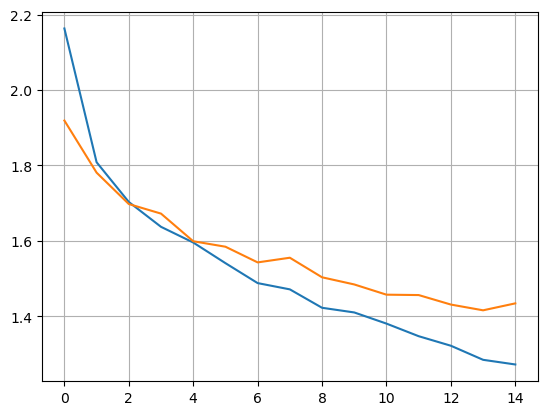

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.show()

# Mallin arviointi
Testin loss on noin 1.42
Testitarkkuus on noin 50%

In [9]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 1s - 3ms/step - accuracy: 0.4964 - loss: 1.4159
Test loss: 1.4158858060836792
Test accuracy: 0.49639999866485596


## Visuaalisten tulosten tulkinta
Pylväsdiagrammi näyttää, kuinka todennäköisesti malli uskoo kuvan kuuluvan jokaiseen kategoriaan.
0 = Airplane

1 = Automobile

2 = Bird

3 = Cat

4 = Deer

5 = Dog

6 = Frog

7 = Horse

8 = Ship

9 = Truck


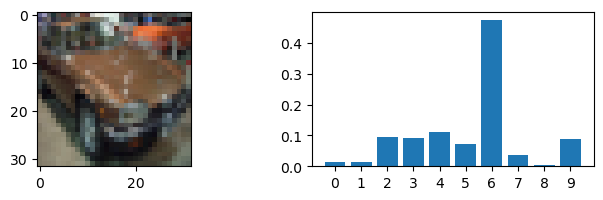

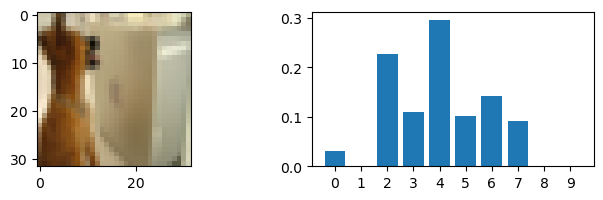

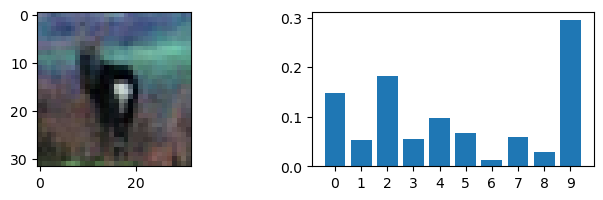

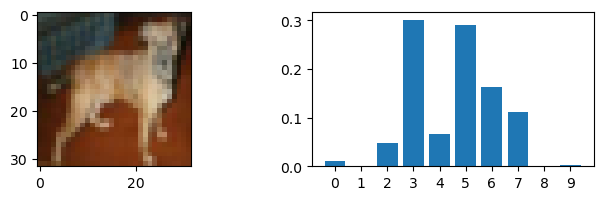

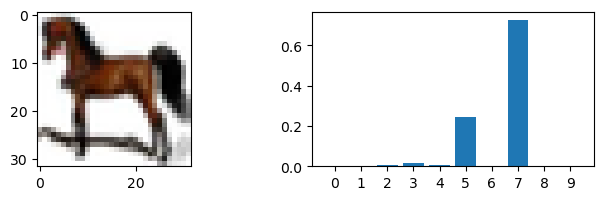

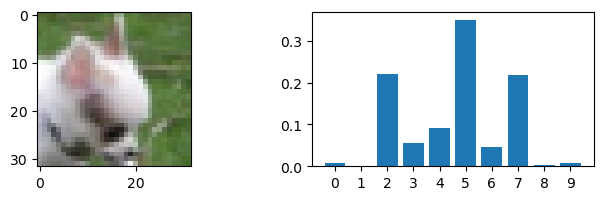

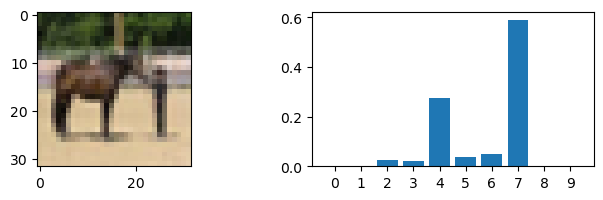

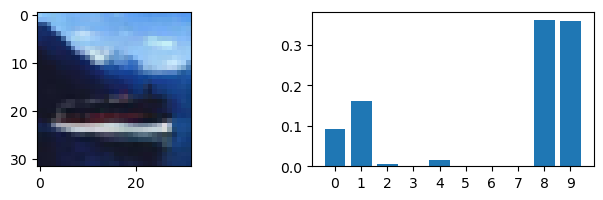

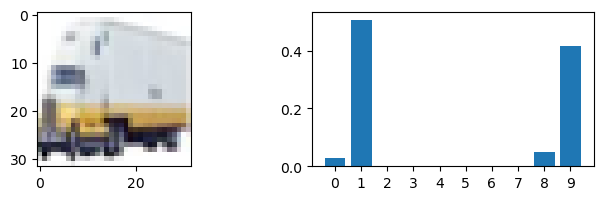

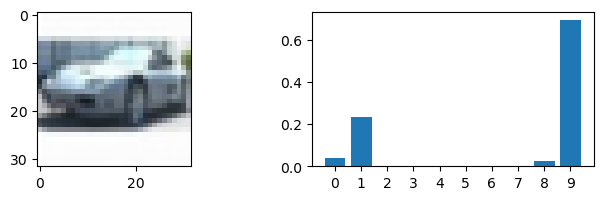

In [10]:
x = x_test
y = model(x)
start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))
    plt.subplot(1,2,1)
    plt.imshow(x[start+k].reshape((32, 32,3)), cmap='gray')
    ind = np.arange(0, 10)
    plt.subplot(1,2,2)
    plt.bar(ind, y[start+k].numpy().flatten())
    plt.xticks(range(10))